In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from numpy.random import Generator, PCG64
rng_pg = Generator(PCG64())
from scipy.optimize import newton, minimize, fsolve
from scipy.optimize import nnls

### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook")
%matplotlib inline

/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/sulab/anaconda3/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.curve_fitting import loss_func_c1, loss_func_l1, loss_func_l2, hl_bsl_fit, bootstrap_hl, bootstrap_hl_fast

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting'

Notebook is in: /home/sulab/tRNA-charge-seq/projects/charge_half-life
Repo is in: /home/sulab/tRNA-charge-seq


### Settings

In [3]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

In [4]:
dir_dict

{'NBdir': '/home/sulab/tRNA-charge-seq/projects/charge_half-life',
 'data_dir': 'data',
 'stats_dir': 'stats_collection',
 'plotting_dir': 'plotting'}

In [5]:
# Get charge dataframe:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
plot_obj.get_charge_df()



In [6]:
plot_obj.charge_df.head(3)

,sample_name_unique,sample_name,replicate,barcode,tRNA_annotation,tRNA_anno_short,tRNA_annotation_len,unique_annotation,codon,anticodon,AA_codon,amino_acid,single_codon,single_aa,mito_codon,Ecoli_ctr,AA_letter,A_count,C_count,count,charge,RPM
0,0m_1,0m,1,l1Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,eColiLys-TTT-1-1,76,True,AAA,TTT,eColiLys-AAA,eColiLys,True,True,False,True,K,10,1876,1886,0.530223,346.747268
1,0m_1,0m,1,l1Sp,Homo_sapiens_mito_tRNA-Ala-TGC,Ala-TGC,72,True,GCA,TGC,Ala-GCA,Ala,True,True,True,False,A,5298,188,5486,96.573095,1008.619041
2,0m_1,0m,1,l1Sp,Homo_sapiens_mito_tRNA-Arg-TCG,Arg-TCG,68,True,CGA,TCG,Arg-CGA,Arg,True,True,True,False,R,13678,561,14239,96.060117,2617.886717


In [7]:
plot_obj.all_stats.head(3)

,sample_name_unique,sample_name,replicate,barcode,tRNA_annotation,tRNA_annotation_len,unique_annotation,5p_cover,align_3p_nt,codon,anticodon,amino_acid,count,AA_codon,tRNA_anno_short,single_codon,single_aa,mito_codon,Ecoli_ctr,AA_letter
0,100p1_v1,100p,1,l1Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,A,AAA,TTT,eColiLys,146,eColiLys-AAA,eColiLys-TTT-1-1,True,True,False,True,K
1,100p1_v1,100p,1,l1Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,False,C,AAA,TTT,eColiLys,1296,eColiLys-AAA,eColiLys-TTT-1-1,True,True,False,True,K
2,100p1_v1,100p,1,l1Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,76,True,True,A,AAA,TTT,eColiLys,67,eColiLys-AAA,eColiLys-TTT-1-1,True,True,False,True,K


In [8]:
plot_obj.charge_filt['tr'].head(3)

,sample_name_unique,sample_name,replicate,barcode,tRNA_annotation,tRNA_anno_short,tRNA_annotation_len,codon,anticodon,AA_codon,amino_acid,AA_letter,mito_codon,Ecoli_ctr,count,A_count,C_count,RPM,charge
0,0m_1,0m,1,l1Sp,Escherichia_coli_str_K_12_substr_MG1655_tRNA-e...,eColiLys-TTT-1-1,76,AAA,TTT,eColiLys-AAA,eColiLys,K,False,True,1886,10,1876,346.747268,0.530223
1,0m_1,0m,1,l1Sp,Homo_sapiens_mito_tRNA-Ala-TGC,Ala-TGC,72,GCA,TGC,Ala-GCA,Ala,A,True,False,5486,5298,188,1008.619041,96.573095
2,0m_1,0m,1,l1Sp,Homo_sapiens_mito_tRNA-Arg-TCG,Arg-TCG,68,CGA,TCG,Arg-CGA,Arg,R,True,False,14239,13678,561,2617.886717,96.060117


In [9]:
set(plot_obj.charge_filt['tr']['tRNA_annotation'])

{'Escherichia_coli_str_K_12_substr_MG1655_tRNA-eColiLys-TTT-1-1',
 'Homo_sapiens_mito_tRNA-Ala-TGC',
 'Homo_sapiens_mito_tRNA-Arg-TCG',
 'Homo_sapiens_mito_tRNA-Asn-GTT',
 'Homo_sapiens_mito_tRNA-Asp-GTC',
 'Homo_sapiens_mito_tRNA-Cys-GCA',
 'Homo_sapiens_mito_tRNA-Gln-TTG',
 'Homo_sapiens_mito_tRNA-Glu-TTC',
 'Homo_sapiens_mito_tRNA-Gly-TCC',
 'Homo_sapiens_mito_tRNA-His-GTG',
 'Homo_sapiens_mito_tRNA-Ile-GAT',
 'Homo_sapiens_mito_tRNA-Leu1-TAG',
 'Homo_sapiens_mito_tRNA-Leu2-TAA',
 'Homo_sapiens_mito_tRNA-Lys-TTT',
 'Homo_sapiens_mito_tRNA-Met-CAT',
 'Homo_sapiens_mito_tRNA-Phe-GAA',
 'Homo_sapiens_mito_tRNA-Pro-TGG',
 'Homo_sapiens_mito_tRNA-Ser1-GCT',
 'Homo_sapiens_mito_tRNA-Ser2-TGA',
 'Homo_sapiens_mito_tRNA-Thr-TGT',
 'Homo_sapiens_mito_tRNA-Trp-TCA',
 'Homo_sapiens_mito_tRNA-Tyr-GTA',
 'Homo_sapiens_mito_tRNA-Val-TAC',
 'Homo_sapiens_tRNA-Ala-AGC-1-1',
 'Homo_sapiens_tRNA-Ala-AGC-10-1',
 'Homo_sapiens_tRNA-Ala-AGC-11-1',
 'Homo_sapiens_tRNA-Ala-AGC-12-1',
 'Homo_sapiens_tRNA-A

In [10]:
charge_df = sample_df.loc[:, ['sample_name_unique', 'hue_value', 'hue_order']].merge(plot_obj.charge_filt['tr'], on='sample_name_unique')

In [11]:
# Enforce minimum read count:
min_count = 500

tann2snu = dict()
for snu, tann, ectr, cnt in zip(charge_df['sample_name_unique'], \
                               charge_df['tRNA_annotation'], \
                               charge_df['Ecoli_ctr'], \
                               charge_df['count']):
    if ectr or cnt < min_count:
        continue
    
    if tann in tann2snu:
        tann2snu[tann].add(snu)
    else:
        tann2snu[tann] = set()
        tann2snu[tann].add(snu)

# Filter based on minimum:
all_snu = set(charge_df['sample_name_unique'])
tann_sele = set()
for tann in tann2snu:
    if tann2snu[tann] == all_snu:
        tann_sele.add(tann)

mask = charge_df['tRNA_annotation'].isin(tann_sele)
filt_df = charge_df[mask].copy()

# Convert time to minutes:
time_list = list()
for sn in filt_df['sample_name']:
    if 'NoOx' in sn:
        time_list.append(None)
    elif 'm' in sn:
        time_list.append(int(sn[:-1]))
    elif 'h' in sn:
        time_list.append(int(sn[:-1])*60)
    else:
        raise Exception('???')
filt_df['Time'] = time_list
filt_df = filt_df[~filt_df['Time'].isna()].copy()

hl_df = filt_df.groupby(['tRNA_annotation', 'tRNA_anno_short', 'tRNA_annotation_len', 'codon', 'anticodon', 'AA_codon', 'amino_acid', 'AA_letter', 'mito_codon', 'Ecoli_ctr']).agg({'RPM': 'mean', 'count': 'mean'}).reset_index()

In [12]:
def plot_hl(df, p_est, ci, plot_return=True, plot_fh=None):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))

    fit_x = np.linspace(df['Time'].min(), df['Time'].max(), 1000)
    fit_y = hl_bsl_fit(fit_x, *p_est)
    fit_yb = hl_bsl_fit(fit_x, *ci[0])
    fit_yt = hl_bsl_fit(fit_x, *ci[1])


    g1 = sns.scatterplot(ax=ax1, data=df, x='Time', y='charge', zorder=10, alpha=0.5)
    g1.set_title('No transform')
    ax1.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax1.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax1.plot(fit_x, fit_y, c='r', zorder=3)


    g2 = sns.scatterplot(ax=ax2, data=df, x='Time', y='charge', zorder=10, alpha=0.5)
    g2.set_title('Log2 y')
    g2.set_yscale('log', base=2)
    ax2.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax2.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax2.plot(fit_x, fit_y, c='r', zorder=3)


    g3 = sns.scatterplot(ax=ax3, data=df, x='Time', y='charge', zorder=10, alpha=0.5)
    g3.set_title('Log2 x')
    g3.set_xscale('log', base=2)
    ax3.plot(fit_x, fit_yb, c='g', ls='--', zorder=1)
    ax3.plot(fit_x, fit_yt, c='g', ls='--', zorder=2)
    ax3.plot(fit_x, fit_y, c='r', zorder=3)

    tRNA_name = df['tRNA_anno_short'].values[0]

    fig.suptitle('{} half-life={:.0f} min, 95% CI ({:.0f}; {:.0f})'.format(tRNA_name, p_est[1], ci[0][1], ci[1][1]), size=16);
    fig.tight_layout()
    
    if not plot_fh is None:
        plot_fh.savefig(fig, bbox_inches='tight')
    else:
        fig.savefig('data/plotting/half-life/{}.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)
    

In [13]:

# residual, hl_p_est, hl_ci_l, hl_ci_u, res_out
res = list()

with PdfPages('data/plotting/half-life/hl-fit.pdf') as pp:
    for tann in hl_df['tRNA_annotation']:
        sample_mask = filt_df['tRNA_annotation'] == tann
        hl_spl = filt_df[sample_mask].copy()
        residual, p_est, ci = bootstrap_hl(hl_spl, Ndraws=1000, BFGS_loss_func=loss_func_l2, lstsq=False)
        aa = hl_spl['tRNA_anno_short'].values[0].split('-')[0]

        plot_hl(hl_spl, p_est, ci, plot_fh=pp, plot_return=False)
        
        res.append([residual, p_est[1], ci[0][1], ci[1][1], (p_est, ci)])


hl_df['hl_residual'] = [row[0] for row in res]
hl_df['hl_p_est'] = [row[1] for row in res]
hl_df['res_ci_l'] = [row[2] for row in res]
hl_df['res_ci_u'] = [row[3] for row in res]
hl_df['res_param'] = [row[4] for row in res]

In [14]:
hl_df.head(3)

,tRNA_annotation,tRNA_anno_short,tRNA_annotation_len,codon,anticodon,AA_codon,amino_acid,AA_letter,mito_codon,Ecoli_ctr,RPM,count,hl_residual,hl_p_est,res_ci_l,res_ci_u,res_param
0,Homo_sapiens_mito_tRNA-Ala-TGC,Ala-TGC,72,GCA,TGC,Ala-GCA,Ala,A,True,False,1052.447795,4656.750000,2.632131,379.600484,365.271422,399.732684,"((95.16399884583868, 379.60048432492886, 1.049..."
1,Homo_sapiens_mito_tRNA-Arg-TCG,Arg-TCG,68,CGA,TCG,Arg-CGA,Arg,R,True,False,2032.805683,9214.772727,1.112844,226.065060,213.427268,242.076958,"((95.26878828786307, 226.06505984327765, 0.962..."
2,Homo_sapiens_mito_tRNA-Asn-GTT,Asn-GTT,76,AAC,GTT,Asn-AAC,Asn,N,True,False,1161.685988,5235.681818,1.942387,94.812156,90.436518,100.243539,"((89.63746676687192, 94.81215643543831, 1.3986..."


In [15]:
hl_df.loc[hl_df['hl_residual'].argmax(), :]

tRNA_annotation                           Homo_sapiens_mito_tRNA-Met-CAT
tRNA_anno_short                                                  Met-CAT
tRNA_annotation_len                                                   71
codon                                                                AUG
anticodon                                                            CAT
AA_codon                                                         Met-AUG
amino_acid                                                           Met
AA_letter                                                              M
mito_codon                                                          True
Ecoli_ctr                                                          False
RPM                                                          2629.794519
count                                                       11847.477273
hl_residual                                                   132.789178
hl_p_est                                           

In [16]:
hl_df.loc[hl_df['hl_p_est'].argmin(), :]

tRNA_annotation                            Homo_sapiens_tRNA-Asn-GTT-6-1
tRNA_anno_short                                              Asn-GTT-6-1
tRNA_annotation_len                                                   77
codon                                                                AAC
anticodon                                                            GTT
AA_codon                                                         Asn-AAC
amino_acid                                                           Asn
AA_letter                                                              N
mito_codon                                                         False
Ecoli_ctr                                                          False
RPM                                                           422.014046
count                                                        1871.818182
hl_residual                                                     2.088913
hl_p_est                                           

In [17]:
hl_df[hl_df['amino_acid'] == 'Met']

,tRNA_annotation,tRNA_anno_short,tRNA_annotation_len,codon,anticodon,AA_codon,amino_acid,AA_letter,mito_codon,Ecoli_ctr,RPM,count,hl_residual,hl_p_est,res_ci_l,res_ci_u,res_param
13,Homo_sapiens_mito_tRNA-Met-CAT,Met-CAT,71,AUG,CAT,Met-AUG,Met,M,True,False,2629.794519,11847.477273,132.789178,1281.023916,1226.394602,1338.093172,"((89.77256340647531, 1281.0239162493733, 2.5),..."
125,Homo_sapiens_tRNA-Met-CAT-1-1,Met-CAT-1-1,76,AUG,CAT,Met-AUG,Met,M,False,False,3124.889336,13937.886364,1.849770,457.546002,443.218921,468.560363,"((96.53867683339918, 457.54600178570723, 0.0),..."
126,Homo_sapiens_tRNA-Met-CAT-3-1,Met-CAT-3-1,76,AUG,CAT,Met-AUG,Met,M,False,False,4518.291850,20140.090909,1.507384,464.207780,449.414336,476.404372,"((96.95562539584552, 464.20778003254236, 0.0),..."
127,Homo_sapiens_tRNA-Met-CAT-4-1,Met-CAT-4-1,76,AUG,CAT,Met-AUG,Met,M,False,False,5081.712632,22618.659091,3.058130,477.582624,458.232100,495.288655,"((97.25039946903787, 477.58262381239155, 0.0),..."
128,Homo_sapiens_tRNA-Met-CAT-6-1,Met-CAT-6-1,76,AUG,CAT,Met-AUG,Met,M,False,False,3477.639882,15506.227273,2.301494,466.372623,452.153932,477.282923,"((96.40714884293403, 466.37262285433815, 0.0),..."


Half-life

$$
N(t) = N_0 \left( \frac{1}{2} \right) ^\frac{t}{t_{1/2}} + N_{\infty}
$$


$$
log_2(N(t) - N_{\infty}) = log_2(N_0) - \frac{t}{t_{1/2}}
$$

$$
log_2(N(t) - N_{\infty}) = log_2(N_0) - t \frac{1}{t_{1/2}}
$$

$$
t_{1/2} = \frac{t}{log_2(N_0) - log_2(N(t) - N_{\infty})}
$$

In [213]:
p_est, ci = bootstrap_hl(hl_spl, Ndraws=1000, BFGS_loss_func=loss_func_l2, lstsq=True)

In [132]:
print(p_est)
print(ci)

(96.00474752710623, 418.44841794653644, 0.42539364086634457)
[(97.05385278784854, 393.6679576101668, 0.42539364086634457), (94.69207270285224, 447.44237397425564, 0.42539364086634457)]


In [118]:
bootstrap_hl(hl_spl, Ndraws=10000, BFGS_loss_func=loss_func_c1, lstsq=True)

((395.8547889285526, 96.79094314272555, 0.8346930017495829),
 array([367.10449724, 428.02401717]))

In [211]:
p_est, ci = bootstrap_hl(hl_spl, Ndraws=1000, BFGS_loss_func=loss_func_l2, lstsq=False)

In [120]:
bootstrap_hl(hl_spl, Ndraws=1000, BFGS_loss_func=loss_func_c1, lstsq=False)

((396.1452773604278, 96.6949805416293, 0.8346930017495829),
 array([372.97732558, 416.04601084]))

In [25]:
# Fast version only works when same number of replicates in all timepoints:
#bootstrap_hl_fast(hl_spl, Ndraws=100000, BFGS_loss_func=loss_func_l2)

In [26]:
#bootstrap_hl_fast(hl_spl, Ndraws=100000, BFGS_loss_func=loss_func_c1)

In [ ]:
#bootstrap_hl_fast(hl_spl, Ndraws=100000, BFGS_loss_func=loss_func_c1, minus_N_bz=0)

In [235]:
hl_spl.head(3)

,sample_name_unique,hue_value,hue_order,sample_name,replicate,barcode,tRNA_annotation,tRNA_anno_short,tRNA_annotation_len,codon,anticodon,AA_codon,amino_acid,AA_letter,mito_codon,Ecoli_ctr,count,A_count,C_count,RPM,charge,Time
206,0m_1,0m,1,0m,1,l1Sp,Homo_sapiens_tRNA-Ser-GCT-1-1,Ser-GCT-1-1,85,AGC,GCT,Ser-AGC,Ser,S,False,False,5746,4699,1047,1049.031736,81.778629,0.0
468,8m_1,8m,3,8m,1,l3Sp,Homo_sapiens_tRNA-Ser-GCT-1-1,Ser-GCT-1-1,85,AGC,GCT,Ser-AGC,Ser,S,False,False,4071,3321,750,1010.884828,81.577008,8.0
735,32m_1,32m,5,32m,1,l5Sp,Homo_sapiens_tRNA-Ser-GCT-1-1,Ser-GCT-1-1,85,AGC,GCT,Ser-AGC,Ser,S,False,False,5499,4382,1117,1002.503067,79.687216,32.0


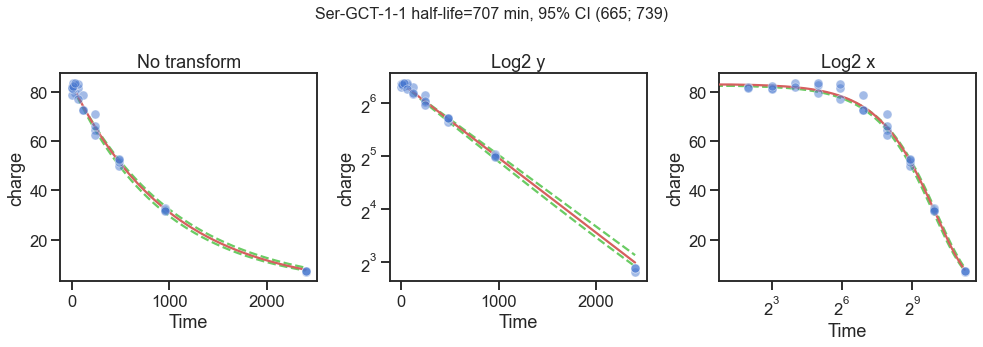

In [238]:
plot_hl(hl_spl, p_est, ci)